Process anndata files and convert them to the appropriate format. We only use gene names that are in the geneformer vocab.

In [1]:
import json
from bionemo.core.data.load import load
from pathlib import Path
import numpy as np

vocab_data_path: Path = (
        load("single_cell/testdata-20241203") / "cellxgene_2023-12-15_small_processed_scdl" / "train" / "geneformer.vocab"
    )
with open(vocab_data_path, "r") as f:
    data = json.load(f)
    gene_list = set(data['vocab'].keys())

In [2]:
import anndata as ad
import os
import shutil

from bionemo.core import BIONEMO_CACHE_DIR
input_dir = "/workspaces/bionemo-framework/adata" #Location of the h5ad file or files

# The expected input is that the feature_ids will be a column in .var
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".h5ad"):
            file_path = os.path.join(root, file)

            # Load AnnData object
            adata = ad.read_h5ad(file_path)

            adata.var['feature_id'] = adata.var.index
            mask = adata.var['feature_id'].isin(gene_list)
            adata = adata[:, mask]
            non_zero_mask = (adata.X != 0).sum(axis=1).A1 > 0 if isinstance(adata.X, np.matrix) else (adata.X != 0).sum(axis=1) > 0
            adata = adata[non_zero_mask]

            adata.write(file_path)


cleanup: bool = True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_classification"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)
data_dir = notebook_workdir / "scdl_dataset"


In [3]:
!convert_h5ad_to_scdl --data-path {input_dir} --save-path {data_dir}

Download geneformer models. 

In [4]:
from bionemo.core.data.load import load


# 106m checkpoint
geneformer_106m = load("geneformer/106M_240530:2.0")
# 10m checkpoint
geneformer_10m = load("geneformer/10M_240530:2.0")
# 10m bionemo2 trained checkpoint
geneformer_10m_bnmo2 = load("geneformer/10M_241113:2.0")


In [5]:
import shutil

from bionemo.core import BIONEMO_CACHE_DIR


cleanup: bool = True
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_celltype_classification"
if cleanup and notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)


In [6]:
result_path_10m = notebook_workdir / "results_10m.pt"

result_path_10m_bnmo2 = notebook_workdir / "results_10m_bnmo2.pt"
results_path_10m_random = notebook_workdir / "results_10m_randomweights.pt"
result_path_106m = notebook_workdir / "results_106m.pt"

In [7]:


!infer_geneformer \
    --data-dir {data_dir} \
    --checkpoint-path {geneformer_106m} \
    --results-path {result_path_106m} \
    --micro-batch-size 32 \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus 1 \
    --include-input-ids \
    --include-unrecognized-vocab-in-dataset


[NeMo W 2025-05-09 20:56:01 nemo_logging:405] Tokenizer vocab file: /home/ubuntu/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.vocab already exists. Overwriting...
[NeMo I 2025-05-09 20:56:01 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-09 20:56:01 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_dictionaries_30m/gene_name_id_dict_gc30M.pkl?download=true
[NeMo I 2025-05-09 20:56:01 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-09 20:56:01 nemo_logging:393] No checksum provided, filename exists. Assuming it is complete.
[NeMo I 2025-05-09 20:56:01 nemo_logging:393] Resource already exists, skipping download: https://huggingface.co/ctheodoris/Geneformer/resolve/m

In [8]:
import torch


infer_Xs_106m = torch.load(result_path_106m / "predictions__rank_0.pt")["embeddings"].float().cpu().numpy()
assert len(adata) == len(infer_Xs_106m), (len(adata), len(infer_Xs_106m))


/tmp/ipykernel_230432/2459020685.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize = 6)


Text(0.5, 1.0, 'Cell type counts for classification dataset')

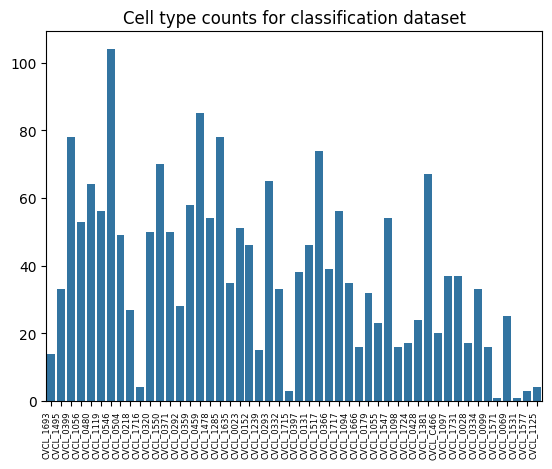

In [9]:
# Now we look at our dataset, how is the distribution of cell counts? Its clear that certain celltypes dominate the dataset, this is good to keep in mind when investigating models.
#  we expect the macro averages and F1-score to be the most reliable metrics for overall performance.
from collections import Counter

import seaborn as sb

infer_metadata = adata.obs
labels = infer_metadata["cell_line"].values
label_counts = Counter(labels)

ax = sb.barplot(x=label_counts.keys(), y=label_counts.values())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize = 6)
ax.set_title("Cell type counts for classification dataset")

In [10]:
# Now we assign integer labels to each of our strings. These do not need to be transformed into one-hot vectors as Random Forest is non-parametric.
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
print(integer_labels)

[43 34 17 ... 13 38  1]


In [11]:
from matplotlib import pyplot

def plot_cm(cm, labels=label_encoder.classes_):
    """Helper function for visualizing accuracy across labels."""
    # # Example confusion matrix (replace with your actual data)
    # _ = np.random.rand(31, 31)

    # Define the bins and the color map
    # bounds = np.arange(0.0, 1.1, 0.1)
    # cmap = ListedColormap(sb.color_palette("RdYlBu_r", len(bounds) - 1))
    # norm = BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1, clip=True)

    # _ = sb.heatmap(cm / cm.sum(axis=0),cmap=cmap, norm=norm, cbar_kws={"ticks": bounds}, linewidths=0.5, linecolor='black', xticklabels=labels, yticklabels=labels)
    _ = sb.heatmap(
        cm / cm.sum(axis=0),
        cmap=sb.color_palette("Blues", as_cmap=True),
        vmin=0,
        vmax=1,
        linewidth=0.1,
        linecolor="lightgrey",
        #xticklabels=labels,
        #yticklabels=labels,
    )
    #pyplot.xticks(rotation=45, ha="right")
    # _ = pyplot.yticks(rotation=0)

In [12]:
def run_benchmark(data, labels, use_pca=True):
    """Run the accuracy, precision, recall, and F1-score benchmarks.

    Args:
        data: (R, C) contains the single cell expression (or whatever feature) in each row.
        labels: (R,) contains the string label for each cell
        use_pca: whether to fit PCA to the data.

    Returns:
        results_out: (dict) contains the accuracy, precision, recall, and F1-score for each class.
        conf_matrix: (R, R) contains the confusion matrix.
    """
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (
        accuracy_score,
        confusion_matrix,
        f1_score,
        make_scorer,
        precision_score,
        recall_score,
        roc_auc_score,
    )
    from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate
    from sklearn.pipeline import Pipeline

    np.random.seed(1337)
    # Define the target dimension 'n_components'
    n_components = 10  # for example, adjust based on your specific needs

    # Create a pipeline that includes Gaussian random projection and RandomForestClassifier
    if use_pca:
        pipeline = Pipeline(
            [
                ("projection", PCA(n_components=n_components)),
                ("classifier", RandomForestClassifier(class_weight="balanced")),
            ]
        )
    else:
        pipeline = Pipeline([("classifier", RandomForestClassifier(class_weight="balanced"))])

    # Set up StratifiedKFold to ensure each fold reflects the overall distribution of labels
    #cv = StratifiedKFold(n_splits=3)


    predictions = cross_val_predict(pipeline, data, labels) #, cv=cv)

    # v Return confusion matrix and metrics.
    conf_matrix = confusion_matrix(labels, predictions)

    return conf_matrix

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/tmp/ipykernel_230432/120117983.py:15: RuntimeWarning: invalid value encountered in divide
  cm / cm.sum(axis=0),


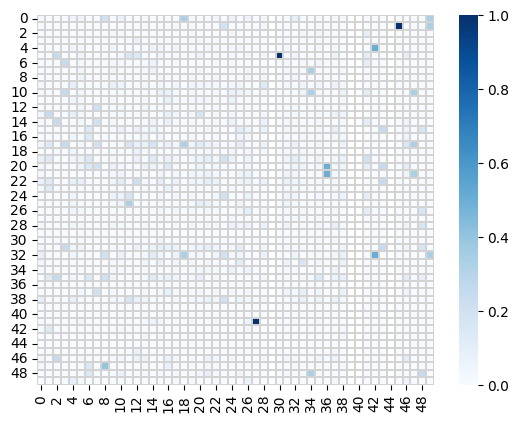

In [13]:
cm_106M = run_benchmark(infer_Xs_106m, integer_labels, use_pca=False)
plot_cm(cm_106M)